<a href="https://colab.research.google.com/github/vivekbiragoni/DL_GAN_24/blob/main/basic_gan_dl_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi


Sun Jan 28 10:42:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
#importing libraries
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [ ]:
# visualization funtion

def show(tensor, ch=1, size=(28, 28), num=16):
  # tensor : 128 X 784
  data = tensor.detach().cpu().view(-1,ch, *size) #128 X  1  X  28  X  28
  grid = make_grid(data[:num], nrow=4).permute(1,2,0)  #1 X  28 X 28  = 28 X 28 X 1 this a convention.. makeing the data compatible with matplotlib
  plt.imshow(grid)
  plt.show()

In [ ]:
#setup of main parameters and hypers
epochs = 500
cur_step = 0   #in each step process one batch so firs image will be 0
info_step = 300   #The info step, this is gonna store every how many steps we want to show in the screen information about the current loss values.
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()
bs = 128
device = "cuda"
dataloader = DataLoader(MNIST(".", download=True, transform=transforms.ToTensor()),shuffle=True,batch_size=bs)


# nor of steps = 60000(nur of images in the mnsit dataset) / 128(images at a time) = 468.75

100%|██████████| 9912422/9912422 [00:00<00:00, 88985108.21it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23290846.73it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22112242.81it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4133332.34it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
#declare models

#generator

def genBlock(inp,out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.BatchNorm1d(out), #normalize
      nn.ReLU(inplace=True)      #brings in non liniearliyt by making negatives as 0s
        )
class Generator(nn.Module):
  def __init__(self, z_dim=64, i_dim=784, h_dim=128): #dimenision of noiseimage 64, output 724=28*28, output of first hidden layer=128
    super().__init__()
    self.gen = nn.Sequential(
        genBlock(z_dim, h_dim), # 64, 128
        genBlock(h_dim, h_dim*2), # 128, 256
        genBlock(h_dim*2, h_dim*4), # 256 x 512
        genBlock(h_dim*4, h_dim*8), # 512, 1024
        nn.Linear(h_dim*8, i_dim), # 1024, 784 (28x28)
        nn.Sigmoid(),
    )

  def forward(self, noise):
       return self.gen(noise)

def gen_noise(number, z_dim):
  return torch.randn(number, z_dim).to(device)



# Discriminator

def discBlock(inp,out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.LeakyReLU(0.2)
  )
class Discriminator(nn.Module):
  def __init__(self, i_dim=784, h_dim=256):
    super().__init__()
    self.disc=nn.Sequential(
        discBlock(i_dim, h_dim*4), # 784, 1024
        discBlock(h_dim*4, h_dim*2), # 1024, 512
        discBlock(h_dim*2, h_dim), # 512, 256
        nn.Linear(h_dim, 1) # 256, 1
    )

  def forward(self, image):
      return self.disc(image)


In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([8, 7, 2, 8, 8, 8, 1, 3, 2, 1])


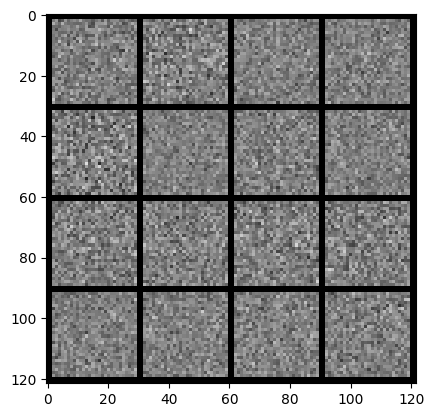

In [ ]:
x,y = next(iter(dataloader))
print(x.shape,y.shape)
print(y[:10])


noise = gen_noise(bs,z_dim)
fake = gen(noise)
show(fake)

In [ ]:
# calculating the loss

# generator loss
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
   noise = gen_noise(number, z_dim)
   fake = gen(noise)
   pred = disc(fake)
   targets=torch.ones_like(pred)
   gen_loss=loss_func(pred,targets)

   return gen_loss


def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
   noise = gen_noise(number, z_dim)
   fake = gen(noise)
   disc_fake = disc(fake.detach())
   disc_fake_targets=torch.zeros_like(disc_fake)
   disc_fake_loss=loss_func(disc_fake, disc_fake_targets)

   disc_real = disc(real)
   disc_real_targets=torch.ones_like(disc_real)
   disc_real_loss=loss_func(disc_real, disc_real_targets)

   disc_loss=(disc_fake_loss+disc_real_loss)/2

   return disc_loss



  0%|          | 0/469 [00:00<?, ?it/s]

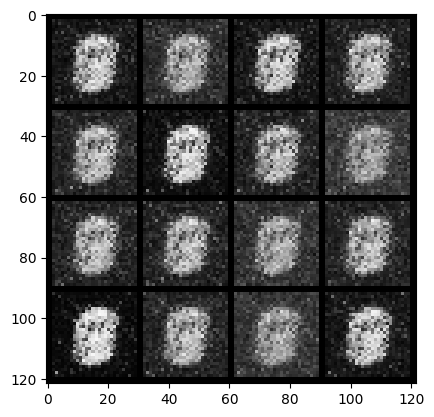

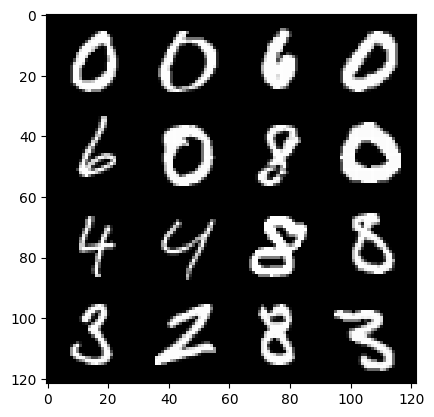

0: step 300 / Gen loss: 2.073775991400083 / disc_loss: 0.3260218840092418


  0%|          | 0/469 [00:00<?, ?it/s]

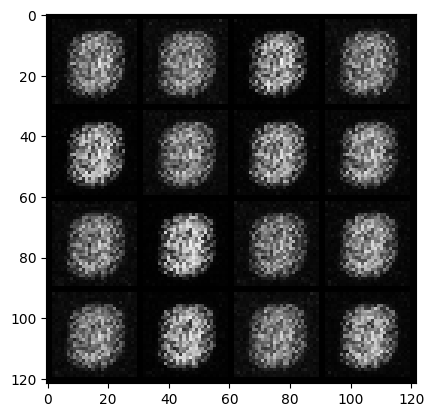

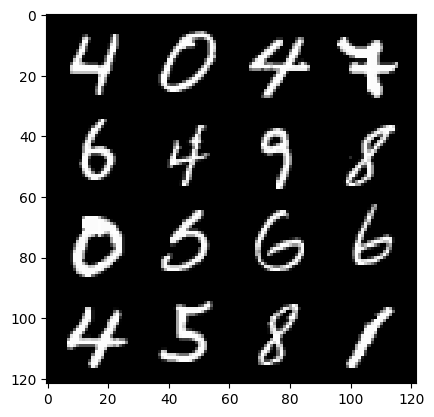

1: step 600 / Gen loss: 3.7053182371457414 / disc_loss: 0.11507372962931786


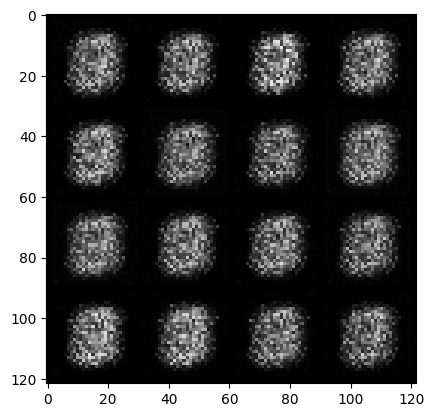

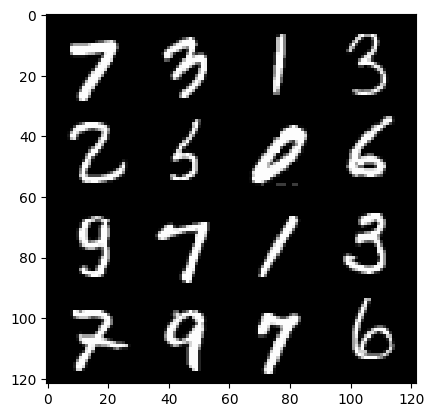

1: step 900 / Gen loss: 3.466022933324178 / disc_loss: 0.0564593258375923


  0%|          | 0/469 [00:00<?, ?it/s]

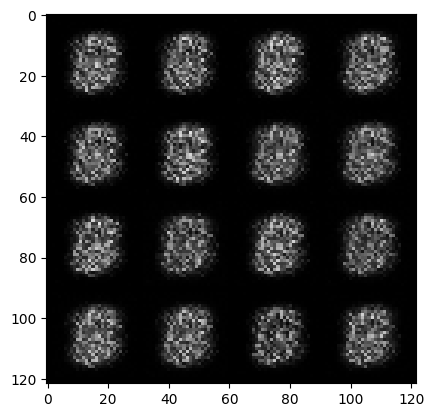

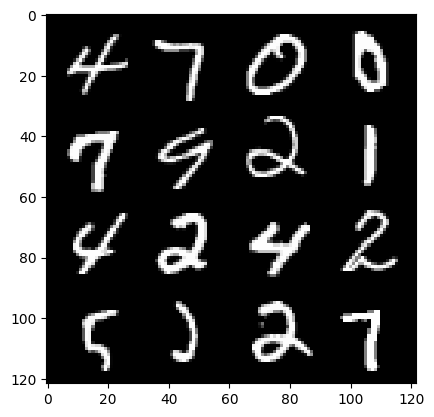

2: step 1200 / Gen loss: 3.5403660400708525 / disc_loss: 0.036759374874333554


  0%|          | 0/469 [00:00<?, ?it/s]

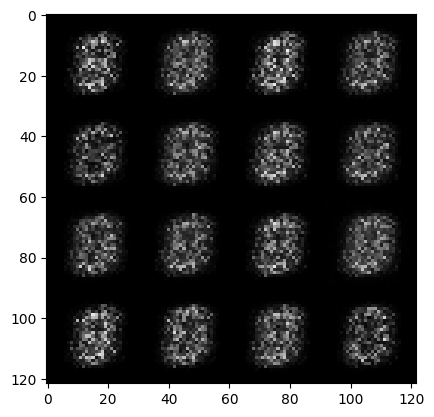

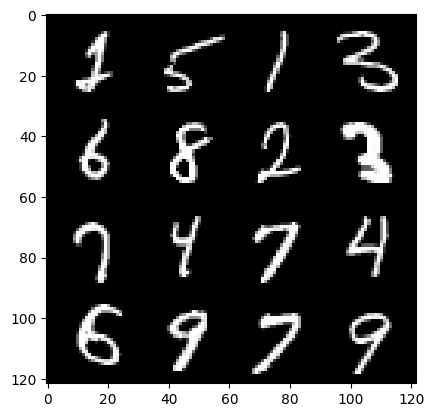

3: step 1500 / Gen loss: 3.4489573852221174 / disc_loss: 0.03958524241422615


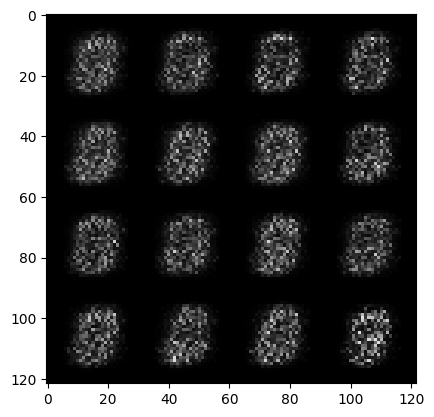

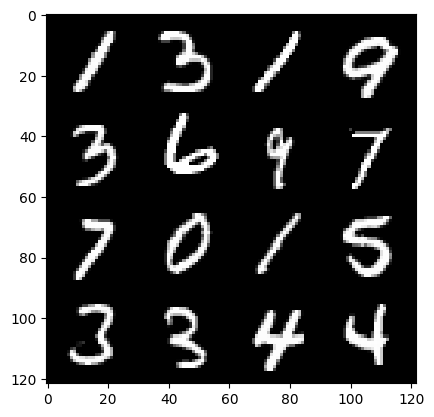

3: step 1800 / Gen loss: 3.5009712862968425 / disc_loss: 0.04026855497931443


  0%|          | 0/469 [00:00<?, ?it/s]

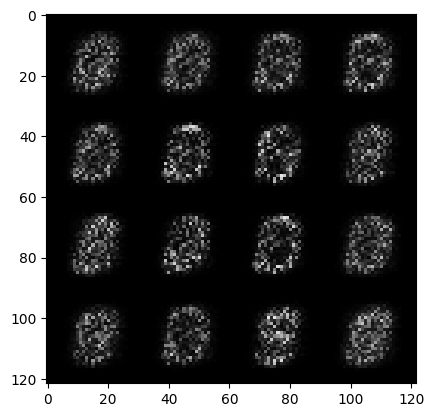

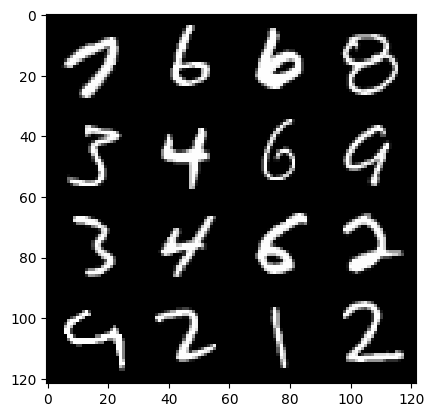

4: step 2100 / Gen loss: 3.660206257502239 / disc_loss: 0.03752307719240584


  0%|          | 0/469 [00:00<?, ?it/s]

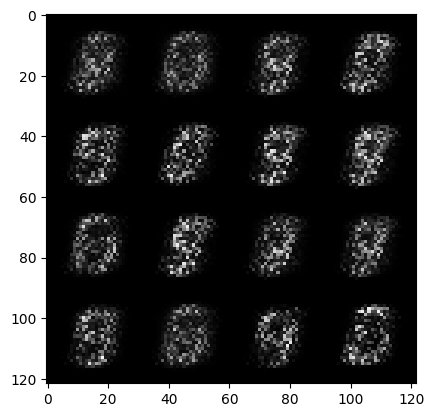

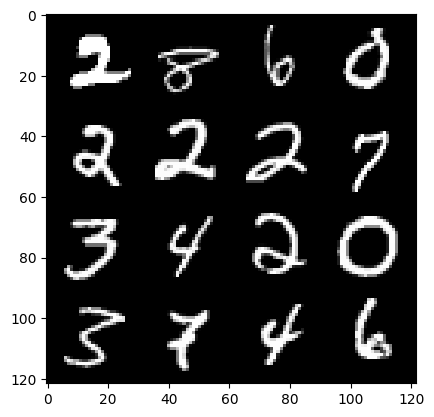

5: step 2400 / Gen loss: 3.9877261384328206 / disc_loss: 0.03204561025525133


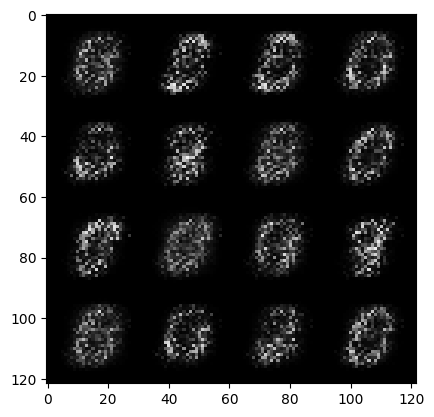

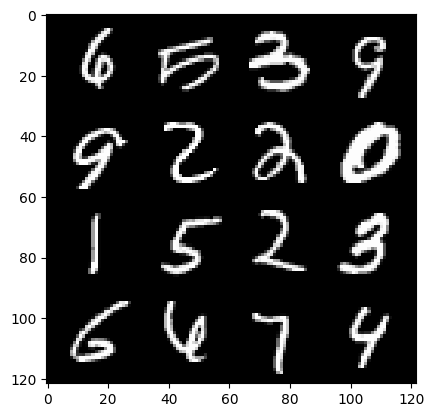

5: step 2700 / Gen loss: 4.34642054955165 / disc_loss: 0.02887026421725749


  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
#60000 / 128(batchsize) = 468.75 = 469 steps in each ephoch
# in the last step there can be lesser than this
for epoch in range(epochs):
  for real, _ in tqdm(dataloader):  #going through datalaoders response
    # Discriminaotr training
    disc_opt.zero_grad() #sets teh gradients for the disc as 0's at the start
    cur_bs = len(real) # real: 128images X 1channel X 28px X 28px... calc again because last one may have diff values
    real = real.view(cur_bs, -1) #128 X 784  reshaping
    real = real.to(device)

    disc_loss = calc_disc_loss(loss_func, gen, disc, cur_bs, real, z_dim)

    disc_loss.backward(retain_graph=True)
    disc_opt.step()


    #generator

    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func,gen,disc,cur_bs,z_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()

    ### visualization & stats
    mean_disc_loss+=disc_loss.item()/info_step
    mean_gen_loss+=gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step>0:
      fake_noise = gen_noise(cur_bs, z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss=0,0
    cur_step+=1
